# Multi-label text classification using BERT

In [1]:
!nvidia-smi

Thu Jul 11 09:48:29 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.58.02              Driver Version: 556.12         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080 ...    On  |   00000000:01:00.0  On |                  N/A |
| N/A   45C    P8             15W /  160W |     844MiB /  16384MiB |     16%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# !pip install transformers

## Imports

In [3]:
import os
from typing import List
import json
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shutil
import sys
import logging 

logging.basicConfig(
     level=logging.INFO, 
     format= '[%(asctime)s|%(levelname)s|%(module)s.py:%(lineno)s] %(message)s',
     datefmt='%H:%M:%S'
 )
import tqdm.notebook as tq
from tqdm import tqdm
# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()
from collections import defaultdict

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel, AdamW

from defi_textmine_2025.data import load_test_raw_data
from defi_textmine_2025.data import TARGET_COL, INTERIM_DIR, MODELS_DIR, submission_path

# BASE_CHECKPOINT = "bert-base-uncased" #"bert-base-multilingual-uncased"
BASE_CHECKPOINT = "bert-base-multilingual-cased"
TASK_NAME = "multilabel_tagged_text"

entity_classes = {'TERRORIST_OR_CRIMINAL', 'LASTNAME', 'LENGTH', 'NATURAL_CAUSES_DEATH', 'COLOR', 'STRIKE', 'DRUG_OPERATION', 'HEIGHT', 'INTERGOVERNMENTAL_ORGANISATION', 'TRAFFICKING', 'NON_MILITARY_GOVERNMENT_ORGANISATION', 'TIME_MIN', 'DEMONSTRATION', 'TIME_EXACT', 'FIRE', 'QUANTITY_MIN', 'MATERIEL', 'GATHERING', 'PLACE', 'CRIMINAL_ARREST', 'CBRN_EVENT', 'ECONOMICAL_CRISIS', 'ACCIDENT', 'LONGITUDE', 'BOMBING', 'MATERIAL_REFERENCE', 'WIDTH', 'FIRSTNAME', 'MILITARY_ORGANISATION', 'CIVILIAN', 'QUANTITY_MAX', 'CATEGORY', 'POLITICAL_VIOLENCE', 'EPIDEMIC', 'TIME_MAX', 'TIME_FUZZY', 'NATURAL_EVENT', 'SUICIDE', 'CIVIL_WAR_OUTBREAK', 'POLLUTION', 'ILLEGAL_CIVIL_DEMONSTRATION', 'NATIONALITY', 'GROUP_OF_INDIVIDUALS', 'QUANTITY_FUZZY', 'RIOT', 'WEIGHT', 'THEFT', 'MILITARY', 'NON_GOVERNMENTAL_ORGANISATION', 'LATITUDE', 'COUP_D_ETAT', 'ELECTION', 'HOOLIGANISM_TROUBLEMAKING', 'QUANTITY_EXACT', 'AGITATING_TROUBLE_MAKING'}
categories_to_check = ['END_DATE', 'GENDER_MALE', 'WEIGHS', 'DIED_IN', 'HAS_FAMILY_RELATIONSHIP', 'IS_DEAD_ON', 'IS_IN_CONTACT_WITH', 'HAS_CATEGORY', 'HAS_CONTROL_OVER', 'IS_BORN_IN', 'IS_OF_SIZE', 'HAS_LATITUDE', 'IS_PART_OF', 'IS_OF_NATIONALITY', 'IS_COOPERATING_WITH', 'DEATHS_NUMBER', 'HAS_FOR_HEIGHT', 'INITIATED', 'WAS_DISSOLVED_IN', 'HAS_COLOR', 'CREATED', 'IS_LOCATED_IN', 'WAS_CREATED_IN', 'IS_AT_ODDS_WITH', 'HAS_CONSEQUENCE', 'HAS_FOR_LENGTH', 'INJURED_NUMBER', 'START_DATE', 'STARTED_IN', 'GENDER_FEMALE', 'HAS_LONGITUDE', 'RESIDES_IN', 'HAS_FOR_WIDTH', 'IS_BORN_ON', 'HAS_QUANTITY', 'OPERATES_IN', 'IS_REGISTERED_AS']

mlb = MultiLabelBinarizer()
mlb.fit([categories_to_check])
logging.info(f"{mlb.classes_=}")

generated_data_dir_path = os.path.join(INTERIM_DIR, "multilabel_tagged_text_dataset")
assert os.path.exists(generated_data_dir_path)

preprocessed_data_dir = os.path.join(INTERIM_DIR, "one_hot_multilabel_tagged_text_dataset")
labeled_preprocessed_data_dir_path = os.path.join(preprocessed_data_dir,"train")
! mkdir -p {labeled_preprocessed_data_dir_path}

model_dir_path = os.path.join(MODELS_DIR, f"finetuned-{BASE_CHECKPOINT}")
! mkdir -p {model_dir_path}
model_dict_state_path = os.path.join(model_dir_path,"MLTC_model_state.bin")

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

[09:48:31|INFO|2626576024.py:43] mlb.classes_=array(['CREATED', 'DEATHS_NUMBER', 'DIED_IN', 'END_DATE', 'GENDER_FEMALE',
       'GENDER_MALE', 'HAS_CATEGORY', 'HAS_COLOR', 'HAS_CONSEQUENCE',
       'HAS_CONTROL_OVER', 'HAS_FAMILY_RELATIONSHIP', 'HAS_FOR_HEIGHT',
       'HAS_FOR_LENGTH', 'HAS_FOR_WIDTH', 'HAS_LATITUDE', 'HAS_LONGITUDE',
       'HAS_QUANTITY', 'INITIATED', 'INJURED_NUMBER', 'IS_AT_ODDS_WITH',
       'IS_BORN_IN', 'IS_BORN_ON', 'IS_COOPERATING_WITH', 'IS_DEAD_ON',
       'IS_IN_CONTACT_WITH', 'IS_LOCATED_IN', 'IS_OF_NATIONALITY',
       'IS_OF_SIZE', 'IS_PART_OF', 'IS_REGISTERED_AS', 'OPERATES_IN',
       'RESIDES_IN', 'STARTED_IN', 'START_DATE', 'WAS_CREATED_IN',
       'WAS_DISSOLVED_IN', 'WEIGHS'], dtype=object)


device(type='cuda')

In [4]:
def load_csv(dir_or_file_path: str, index_col=None, sep=',') -> pd.DataFrame:
    if os.path.isdir(dir_or_file_path):
        all_files = glob.glob(os.path.join(dir_or_file_path , "*.csv"))  
    else:
        assert dir_or_file_path.endswith(".csv")
        all_files = [dir_or_file_path]
    assert len(all_files) > 0
    return pd.concat([pd.read_csv(filename, index_col=index_col, header=0, sep=sep) for filename in all_files], axis=0, ignore_index=True)

def process_data(data: pd.DataFrame) -> pd.DataFrame:
    return pd.concat([data, pd.DataFrame(mlb.transform(data[TARGET_COL]), columns=mlb.classes_, index=data.index)], axis=1) # .drop([TARGET_COL], axis=1)


def format_relations_str_to_list(labels_as_str: str) -> List[str]:
    return json.loads(
        labels_as_str.replace("{", "[").replace("}", "]").replace("'", '"')
    )  if not pd.isnull(labels_as_str) else []


def process_csv_to_csv(in_dir_or_file_path: str, out_dir_path: str) -> None:
    """Convert labels, i.e. list of relations category, into one-hot vectors

    Args:
        in_dir_or_file_path (str): str
        out_dir_path (str): str
    """
    if os.path.isdir(in_dir_or_file_path):
        all_files = glob.glob(os.path.join(in_dir_or_file_path , "*.csv"))  
    else:
        assert in_dir_or_file_path.endswith(".csv")
        all_files = [in_dir_or_file_path]
    for filename in (pb:=tqdm(all_files)):
        pb.set_description(filename)
        preprocessed_data_filename = os.path.join(out_dir_path, os.path.basename(filename))
        process_data(load_csv(filename).assign(**{TARGET_COL: lambda df: df[TARGET_COL].apply(format_relations_str_to_list)})).to_csv(preprocessed_data_filename, sep="\t")

## Preprocess and save data

- load generated data
- convert to dataframe
- convert categories into one-hot labels
- save into a tsv file

In [5]:
process_csv_to_csv(os.path.join(generated_data_dir_path, "train"), labeled_preprocessed_data_dir_path)

data/defi-text-mine-2025/interim/multilabel_tagged_text_dataset/train/41884.csv: 100%|██████████| 800/800 [00:10<00:00, 79.10it/s]


## Load preprocessed data

In [6]:
labeled_df = load_csv(labeled_preprocessed_data_dir_path, index_col=0, sep='\t')

In [7]:
labeled_df

,text_index,e1,e2,text,relations,CREATED,DEATHS_NUMBER,DIED_IN,END_DATE,GENDER_FEMALE,...,IS_OF_SIZE,IS_PART_OF,IS_REGISTERED_AS,OPERATES_IN,RESIDES_IN,STARTED_IN,START_DATE,WAS_CREATED_IN,WAS_DISSOLVED_IN,WEIGHS
0,2576,0,0,"Le matin du 10 janvier 2010, Arthur et Jacques...",[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2576,1,0,"Le matin du 10 janvier 2010, Arthur et Jacques...",[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2576,0,1,"Le matin du 10 janvier 2010, Arthur et Jacques...",['HAS_CONSEQUENCE'],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2576,1,1,"Le matin du 10 janvier 2010, Arthur et Jacques...",[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2576,2,0,"Le matin du 10 janvier 2010, Arthur et Jacques...",[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411934,41884,25,23,"Le 14 janvier 2014, en pleine Sibérie, dans un...",[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
411935,41884,23,25,"Le 14 janvier 2014, en pleine Sibérie, dans un...",[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
411936,41884,25,24,"Le 14 janvier 2014, en pleine Sibérie, dans un...",[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
411937,41884,24,25,"Le 14 janvier 2014, en pleine Sibérie, dans un...",[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Train-Validation split

- split such that each category exist at least in the train dataset

In [8]:
mlb.classes_

array(['CREATED', 'DEATHS_NUMBER', 'DIED_IN', 'END_DATE', 'GENDER_FEMALE',
       'GENDER_MALE', 'HAS_CATEGORY', 'HAS_COLOR', 'HAS_CONSEQUENCE',
       'HAS_CONTROL_OVER', 'HAS_FAMILY_RELATIONSHIP', 'HAS_FOR_HEIGHT',
       'HAS_FOR_LENGTH', 'HAS_FOR_WIDTH', 'HAS_LATITUDE', 'HAS_LONGITUDE',
       'HAS_QUANTITY', 'INITIATED', 'INJURED_NUMBER', 'IS_AT_ODDS_WITH',
       'IS_BORN_IN', 'IS_BORN_ON', 'IS_COOPERATING_WITH', 'IS_DEAD_ON',
       'IS_IN_CONTACT_WITH', 'IS_LOCATED_IN', 'IS_OF_NATIONALITY',
       'IS_OF_SIZE', 'IS_PART_OF', 'IS_REGISTERED_AS', 'OPERATES_IN',
       'RESIDES_IN', 'STARTED_IN', 'START_DATE', 'WAS_CREATED_IN',
       'WAS_DISSOLVED_IN', 'WEIGHS'], dtype=object)

In [9]:
labeled_df[mlb.classes_].sum(axis=0).sort_values()

HAS_LATITUDE                 10
HAS_LONGITUDE                12
HAS_FOR_HEIGHT               12
WAS_DISSOLVED_IN             14
HAS_FOR_WIDTH                14
WAS_CREATED_IN               15
HAS_FOR_LENGTH               16
IS_BORN_ON                   20
IS_REGISTERED_AS             34
WEIGHS                       41
DIED_IN                      41
IS_BORN_IN                   50
IS_DEAD_ON                   68
INJURED_NUMBER               70
DEATHS_NUMBER                75
HAS_COLOR                    91
CREATED                     126
IS_OF_NATIONALITY           179
HAS_QUANTITY                191
HAS_FAMILY_RELATIONSHIP     222
RESIDES_IN                  222
IS_COOPERATING_WITH         372
GENDER_FEMALE               414
IS_OF_SIZE                  438
INITIATED                   469
HAS_CONSEQUENCE             769
END_DATE                    874
HAS_CATEGORY                894
GENDER_MALE                 908
START_DATE                 1034
IS_PART_OF                 1462
IS_AT_OD

In [10]:
labeled_df.query("HAS_FOR_HEIGHT==1")[mlb.classes_].sum(axis=0)

CREATED                     0
DEATHS_NUMBER               0
DIED_IN                     0
END_DATE                    0
GENDER_FEMALE               0
GENDER_MALE                 0
HAS_CATEGORY                0
HAS_COLOR                   0
HAS_CONSEQUENCE             0
HAS_CONTROL_OVER            0
HAS_FAMILY_RELATIONSHIP     0
HAS_FOR_HEIGHT             12
HAS_FOR_LENGTH              0
HAS_FOR_WIDTH               0
HAS_LATITUDE                0
HAS_LONGITUDE               0
HAS_QUANTITY                0
INITIATED                   0
INJURED_NUMBER              0
IS_AT_ODDS_WITH             0
IS_BORN_IN                  0
IS_BORN_ON                  0
IS_COOPERATING_WITH         0
IS_DEAD_ON                  0
IS_IN_CONTACT_WITH          0
IS_LOCATED_IN               0
IS_OF_NATIONALITY           0
IS_OF_SIZE                  0
IS_PART_OF                  0
IS_REGISTERED_AS            0
OPERATES_IN                 0
RESIDES_IN                  0
STARTED_IN                  0
START_DATE

In [11]:
df_train, df_valid = train_test_split(labeled_df, test_size = 0.2, shuffle=True, random_state=42)

In [12]:
df_train[mlb.classes_].sum(axis=0).sort_values()

HAS_LATITUDE                  8
HAS_FOR_HEIGHT                9
HAS_LONGITUDE                10
WAS_CREATED_IN               11
WAS_DISSOLVED_IN             11
HAS_FOR_LENGTH               11
HAS_FOR_WIDTH                12
IS_BORN_ON                   19
IS_REGISTERED_AS             28
DIED_IN                      34
WEIGHS                       35
IS_BORN_IN                   40
IS_DEAD_ON                   49
INJURED_NUMBER               59
DEATHS_NUMBER                60
HAS_COLOR                    77
CREATED                     101
IS_OF_NATIONALITY           144
HAS_QUANTITY                157
HAS_FAMILY_RELATIONSHIP     171
RESIDES_IN                  172
IS_COOPERATING_WITH         311
GENDER_FEMALE               323
IS_OF_SIZE                  346
INITIATED                   389
HAS_CONSEQUENCE             631
END_DATE                    684
HAS_CATEGORY                708
GENDER_MALE                 715
START_DATE                  805
IS_PART_OF                 1158
IS_AT_OD

In [13]:
df_valid[mlb.classes_].sum(axis=0).sort_values()

IS_BORN_ON                    1
HAS_LONGITUDE                 2
HAS_LATITUDE                  2
HAS_FOR_WIDTH                 2
WAS_DISSOLVED_IN              3
HAS_FOR_HEIGHT                3
WAS_CREATED_IN                4
HAS_FOR_LENGTH                5
WEIGHS                        6
IS_REGISTERED_AS              6
DIED_IN                       7
IS_BORN_IN                   10
INJURED_NUMBER               11
HAS_COLOR                    14
DEATHS_NUMBER                15
IS_DEAD_ON                   19
CREATED                      25
HAS_QUANTITY                 34
IS_OF_NATIONALITY            35
RESIDES_IN                   50
HAS_FAMILY_RELATIONSHIP      51
IS_COOPERATING_WITH          61
INITIATED                    80
GENDER_FEMALE                91
IS_OF_SIZE                   92
HAS_CONSEQUENCE             138
HAS_CATEGORY                186
END_DATE                    190
GENDER_MALE                 193
START_DATE                  229
IS_AT_ODDS_WITH             292
IS_PART_

In [14]:
df_train_with_relation = df_train[df_train[mlb.classes_].sum(axis=1) >= 1]
df_train_with_relation.shape

(21250, 42)

In [15]:
df_train_without_relation = df_train[df_train[mlb.classes_].sum(axis=1) == 0]
df_train_without_relation.shape

(308301, 42)

In [16]:
# sample train data without relation as much as thode with relations
# don't sample validation data as we are not suppose to know which pair of entities has a relation
df_train = pd.concat([df_train_with_relation, df_train_without_relation.sample(n=df_train_with_relation.shape[0])])
df_train.shape

(42500, 42)

## Create the tokenized datasets for model input

In [17]:
# Hyperparameters
MAX_LEN = 300  # TODO: increase
tokenizer = BertTokenizer.from_pretrained(BASE_CHECKPOINT)
task_special_tokens = ["<e1>", "</e1>", "<e2>", "</e2>"] + [
    f"<{entity_class}>" for entity_class in entity_classes
]
# add special tokens to the tokenizer
num_added_tokens = tokenizer.add_tokens(task_special_tokens, special_tokens=False)
num_added_tokens

/home/tagny/.pyenv/versions/3.11.8/envs/kgl11/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


59

In [18]:
# Test the tokenizer
test_text = "La <e2><NON_MILITARY_GOVERNMENT_ORGANISATION>police</e2> tchèque a <e2><NON_MILITARY_GOVERNMENT_ORGANISATION>mis la main</e2> sur le couple responsable d'un trafic d'œuvres d'art. Il s'agit de <e1><TERRORIST_OR_CRIMINAL>Patel</e1> et Mirna Maroski. Une <e2><NON_MILITARY_GOVERNMENT_ORGANISATION>perquisition</e2> à leur domicile a permis de retrouver une centaine de tableaux d'artistes européens. Il y avait également des pots en céramique et en porcelaine d'origine chinoise, ainsi que plusieurs faux documents de voyage. Les époux Maroski ont été conduits au poste de <e2><NON_MILITARY_GOVERNMENT_ORGANISATION>police</e2> dans un véhicule blindé. Mirna Maroski s'est évanouie une fois arrivée au poste. Elle a été amenée en ambulance au CHU de Motol où elle a été soignée. Monsieur Sergueï Alekseï, le directeur de l'hôpital, a demandé à ses collaborateurs d'être vigilants et de ne pas se laisser corrompre par la criminelle."
# generate encodings
encodings = tokenizer.encode_plus(test_text, 
                                  add_special_tokens = True,
                                  max_length = MAX_LEN,
                                  truncation = True,
                                  padding = "max_length", 
                                  return_attention_mask = True, 
                                  return_tensors = "pt")
# we get a dictionary with three keys (see: https://huggingface.co/transformers/glossary.html) 
encodings

{'input_ids': tensor([[   101,  10159, 119549, 119593,  15034, 119550,  71892,    169, 119549,
         119593,  12606,  10109,  12126, 119550,  10326,  10141,  20969,  25360,
            172,    112,  10119,  71720,    172,    112,  25991,    172,    112,
          11938,    119,  10282,    187,    112,  20735,  10104, 119547, 119571,
         104733, 119548,  10131,  43209,  10219,  15734,  10310,  10506,    119,
          13509, 119549, 119593,  10178,  53499,  25322, 119550,    254,  11807,
          65439,    169,  38262,  10104,  65916,  10231,  32882,  24173,  10104,
          70889,    172,    112,  25372,  73022,    119,  10282,    193,  13464,
          12091,  10139,  15050,  10107,  10110,    171,  35328,  63008,  10131,
          10110,  10183,  32942,  24173,    172,    112,  13588,  90308,    117,
          12138,  10121,  13102,  82568,  21784,  10104,  28793,    119,  10468,
         102182,  15734,  10310,  10506,  11378,  10845,  46217,  10107,  10257,
          1895

In [19]:
tokenizer.batch_decode(encodings['input_ids'])

["[CLS] La <e2> <NON_MILITARY_GOVERNMENT_ORGANISATION> police </e2> tchèque a <e2> <NON_MILITARY_GOVERNMENT_ORGANISATION> mis la main </e2> sur le couple responsable d'un trafic d'œuvres d'art. Il s'agit de <e1> <TERRORIST_OR_CRIMINAL> Patel </e1> et Mirna Maroski. Une <e2> <NON_MILITARY_GOVERNMENT_ORGANISATION> perquisition </e2> à leur domicile a permis de retrouver une centaine de tableaux d'artistes européens. Il y avait également des pots en céramique et en porcelaine d'origine chinoise, ainsi que plusieurs faux documents de voyage. Les époux Maroski ont été conduits au poste de <e2> <NON_MILITARY_GOVERNMENT_ORGANISATION> police </e2> dans un véhicule blindé. Mirna Maroski s'est évanouie une fois arrivée au poste. Elle a été amenée en ambulance au CHU de Motol où elle a été soignée. Monsieur Sergueï Alekseï, le directeur de l'hôpital, a demandé à ses collaborateurs d'être vigilants et de ne pas se laisser corrompre par la criminelle. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

In [20]:
len(tokenizer)

119606

In [21]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        # self.e1 = list(df['e1'])
        # self.e1 = list(df['e1'])
        # self.text_indexes = list(df['text_index'])
        self.title = list(df['text'])
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        text = str(self.title[index])
        text = " ".join(text.split())
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'title': text,
            # 'text_index': self.text_index[index],
            # 'e1': self.e1[index],
            # 'e2': self.e2[index],
        }

In [22]:
# most_common_categories = df_train[mlb.classes_].sum().sort_values(ascending=False).index[:7]
# logging.info(most_common_categories)
# # target_list = mlb.classes_.tolist()
# target_list = most_common_categories
target_list = mlb.classes_
logging.info(f"{len(target_list)} categories = {target_list}")

[09:48:47|INFO|1100424365.py:6] 37 categories = ['CREATED' 'DEATHS_NUMBER' 'DIED_IN' 'END_DATE' 'GENDER_FEMALE'
 'GENDER_MALE' 'HAS_CATEGORY' 'HAS_COLOR' 'HAS_CONSEQUENCE'
 'HAS_CONTROL_OVER' 'HAS_FAMILY_RELATIONSHIP' 'HAS_FOR_HEIGHT'
 'HAS_FOR_LENGTH' 'HAS_FOR_WIDTH' 'HAS_LATITUDE' 'HAS_LONGITUDE'
 'HAS_QUANTITY' 'INITIATED' 'INJURED_NUMBER' 'IS_AT_ODDS_WITH'
 'IS_BORN_IN' 'IS_BORN_ON' 'IS_COOPERATING_WITH' 'IS_DEAD_ON'
 'IS_IN_CONTACT_WITH' 'IS_LOCATED_IN' 'IS_OF_NATIONALITY' 'IS_OF_SIZE'
 'IS_PART_OF' 'IS_REGISTERED_AS' 'OPERATES_IN' 'RESIDES_IN' 'STARTED_IN'
 'START_DATE' 'WAS_CREATED_IN' 'WAS_DISSOLVED_IN' 'WEIGHS']


In [23]:
df_train.shape, df_valid.shape

((42500, 42), (82388, 42))

In [24]:
train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN, target_list)
valid_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN, target_list)

In [25]:
# testing the dataset
next(iter(train_dataset))

{'input_ids': tensor([   101,  10281,    129,  13430,  10252,    117,  10119,  63181,    169,
          14444,  13991,    254,  10109,  11859,  55166,  25433,    107,  38571,
          55166,  10310,    107,  10104,  27913,    119,  13509,  21632,  10112,
          51396,  11270,  10104,  34055,    169,  28121,  25790,  11246,  10231,
          53021,  10355,    169,  10845, 107181,    172,    112,  10119,  76609,
            119,  10243,  15533,  15304,    117,  10152,  58768,  11008,  13546,
          11378, 108360,  10109,  11859,  55166,  25433,  10131,  10974, 119549,
         119576,  11372,  69198,  10943, 119550,    119, 119547, 119580,  17926,
          14925,  38937,  13005, 119548,    117,  18982,  10104,  11844,  13116,
          49523,  27749,  29434,  10131,  25360,  10139,  82427,  17824,    118,
          10514,  35407,  10901,  10104,  10109,  11743,    117,  10176,  10139,
          89387,  10138,    172,    112,  10231,  48432,  10460,  10312,  13950,
            119

## Create data loaders

In [26]:
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32

# Data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

## Prepare the model to trained

In [27]:
class BERTClass(torch.nn.Module):
    def __init__(self, tokenizer: BertTokenizer):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained(BASE_CHECKPOINT, return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, len(target_list))
        # if you want to add new tokens to the vocabulary, then in general you’ll need to resize the embedding layers with
        # Source https://discuss.huggingface.co/t/adding-new-tokens-while-preserving-tokenization-of-adjacent-tokens/12604
        self.bert_model.resize_token_embeddings(len(tokenizer))

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids, 
            attention_mask=attn_mask, 
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass(tokenizer)

# # Freezing BERT layers: (tested, weaker convergence)
# for param in model.bert_model.parameters():
#     param.requires_grad = False

model.to(device)

/home/tagny/.pyenv/versions/3.11.8/envs/kgl11/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119606, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

In [28]:
# BCEWithLogitsLoss combines a Sigmoid layer and the BCELoss in one single class. 
# This version is more numerically stable than using a plain Sigmoid followed 
# by a BCELoss as, by combining the operations into one layer, 
# we take advantage of the log-sum-exp trick for numerical stability.
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [29]:
# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-5)         

/home/tagny/.pyenv/versions/3.11.8/envs/kgl11/lib/python3.11/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Function to tain the model

In [30]:
# Training of the model for one epoch
def train_model(training_loader, model, optimizer):
    predictions = []
    prediction_probs = []
    target_values = []
    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to training mode (activate dropout, batch norm)
    model.train()
    # initialize the progress bar
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader), 
                      leave=True, colour='steelblue')
    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        # forward
        outputs = model(ids, mask, token_type_ids) # (batch,predict)=(32,37)
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())
        # training accuracy, apply sigmoid, round (apply thresh 0.5)
        # outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        # targets = targets.cpu().detach().numpy()
        # correct_predictions += np.sum(outputs==targets)
        # num_samples += targets.size   # total number of elements in the 2D array
        outputs = torch.sigmoid(outputs).cpu().detach()
        # thresholding at 0.5
        preds = outputs.round()
        targets = targets.cpu().detach()
        correct_predictions += np.sum(preds.numpy()==targets.numpy())
        num_samples += targets.numpy().size   # total number of elements in the 2D array
        
        # thresholding at 0.5
        preds = outputs.round()        
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        target_values.extend(targets)

        # backward
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # grad descent step
        optimizer.step()
        # Update progress bar
        #loop.set_description(f"")
        #loop.set_postfix(batch_loss=loss)

    # returning: trained model, model accuracy, mean loss
    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    target_values = torch.stack(target_values)    

    return model, float(correct_predictions)/num_samples, f1_score(target_values, predictions, average="macro", zero_division=0), np.mean(losses)
    # return model, float(correct_predictions)/num_samples, np.mean(losses)

# torch.cuda.empty_cache()
# train_model(train_data_loader, model, optimizer)

## Function to evaluate the model

In [31]:
def get_predictions(model, data_loader):
    """
    Outputs:
      predictions - 
    """
    model = model.eval()
    
    titles = []
    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
      for data in tqdm(data_loader, "training"):
        title = data["title"]
        ids = data["input_ids"].to(device, dtype = torch.long)
        mask = data["attention_mask"].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data["targets"].to(device, dtype = torch.float)
        
        outputs = model(ids, mask, token_type_ids)
        # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
        outputs = torch.sigmoid(outputs).detach().cpu()
        # thresholding at 0.5
        preds = outputs.round()
        targets = targets.detach().cpu()

        titles.extend(title)
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        target_values.extend(targets)
    
    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    target_values = torch.stack(target_values)
    
    return titles, predictions, prediction_probs, target_values


def eval_model(validation_loader, model):    
    predictions = []
    prediction_probs = []
    target_values = []
    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to eval mode (turn off dropout, fix batch norm)
    model.eval()

    with torch.no_grad():
        # for batch_idx, data in tqdm(enumerate(validation_loader, 0), "evaluating"):
        for data in tqdm(validation_loader, "evaluating"):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # validation accuracy
            # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).cpu().detach()
            # thresholding at 0.5
            preds = outputs.round()
            targets = targets.cpu().detach()
            correct_predictions += np.sum(preds.numpy()==targets.numpy())
            num_samples += targets.numpy().size   # total number of elements in the 2D array

            predictions.extend(preds)
            prediction_probs.extend(outputs)
            target_values.extend(targets)
            # break
    
    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    target_values = torch.stack(target_values)    

    return float(correct_predictions)/num_samples, f1_score(target_values, predictions, average="macro", zero_division=0), np.mean(losses)


# eval_model(train_data_loader, model)

## Model Training

In [32]:
EPOCHS = 20
LEARNING_RATE = 1e-04
# THRESHOLD = 0.5 # threshold for the sigmoid
PATIENCE = 4
n_not_better_steps = 0
history = defaultdict(list)
best_f1_macro = 0
# assert not os.path.exists(model_dict_state_path), "The trained model is already serialized at {model_dict_state_path}"

if not os.path.exists(os.path.dirname(model_dict_state_path)):
    os.makedirs(os.path.dirname(model_dict_state_path))

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_f1_macro, train_loss = train_model(train_data_loader, model, optimizer)
    val_acc, val_f1_macro, val_loss = eval_model(val_data_loader, model)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_f1_macro={train_f1_macro:.4f}, val_f1_macro={val_f1_macro:.4f}')

    history['train_acc'].append(train_acc)
    history['train_f1_macro'].append(train_f1_macro)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_f1_macro'].append(val_f1_macro)
    history['val_loss'].append(val_loss)
    # save the best model
    if val_f1_macro > best_f1_macro:
        torch.save(model.state_dict(), model_dict_state_path)
        best_f1_macro = val_f1_macro
        n_not_better_steps = 0
    else: # check for early stopping
        n_not_better_steps += 1
        if n_not_better_steps >= PATIENCE:
            break
    

Epoch 1/20


  0%|          | 0/1329 [00:00<?, ?it/s]

evaluating: 100%|██████████| 2575/2575 [10:44<00:00,  3.99it/s]


train_loss=0.1135, val_loss=0.0246 train_f1_macro=0.0026, val_f1_macro=0.0000
Epoch 2/20


  0%|          | 0/1329 [00:00<?, ?it/s]

evaluating: 100%|██████████| 2575/2575 [10:44<00:00,  3.99it/s]


train_loss=0.0511, val_loss=0.0127 train_f1_macro=0.0421, val_f1_macro=0.1007
Epoch 3/20


  0%|          | 0/1329 [00:00<?, ?it/s]

evaluating: 100%|██████████| 2575/2575 [11:54<00:00,  3.60it/s]


train_loss=0.0329, val_loss=0.0098 train_f1_macro=0.1430, val_f1_macro=0.1214
Epoch 4/20


  0%|          | 0/1329 [00:00<?, ?it/s]

evaluating: 100%|██████████| 2575/2575 [11:58<00:00,  3.59it/s]


train_loss=0.0254, val_loss=0.0105 train_f1_macro=0.2111, val_f1_macro=0.1717
Epoch 5/20


  0%|          | 0/1329 [00:00<?, ?it/s]

evaluating: 100%|██████████| 2575/2575 [11:57<00:00,  3.59it/s]


train_loss=0.0211, val_loss=0.0078 train_f1_macro=0.2662, val_f1_macro=0.1818
Epoch 6/20


  0%|          | 0/1329 [00:00<?, ?it/s]

evaluating: 100%|██████████| 2575/2575 [11:56<00:00,  3.60it/s]


train_loss=0.0181, val_loss=0.0093 train_f1_macro=0.3017, val_f1_macro=0.1924
Epoch 7/20


  0%|          | 0/1329 [00:00<?, ?it/s]

evaluating: 100%|██████████| 2575/2575 [11:57<00:00,  3.59it/s]


train_loss=0.0159, val_loss=0.0085 train_f1_macro=0.3311, val_f1_macro=0.2211
Epoch 8/20


  0%|          | 0/1329 [00:00<?, ?it/s]

evaluating: 100%|██████████| 2575/2575 [11:58<00:00,  3.58it/s]


train_loss=0.0140, val_loss=0.0065 train_f1_macro=0.3584, val_f1_macro=0.2249
Epoch 9/20


  0%|          | 0/1329 [00:00<?, ?it/s]

evaluating: 100%|██████████| 2575/2575 [11:58<00:00,  3.58it/s]


train_loss=0.0124, val_loss=0.0071 train_f1_macro=0.3868, val_f1_macro=0.2604
Epoch 10/20


  0%|          | 0/1329 [00:00<?, ?it/s]

evaluating: 100%|██████████| 2575/2575 [11:59<00:00,  3.58it/s]


train_loss=0.0109, val_loss=0.0092 train_f1_macro=0.4312, val_f1_macro=0.2697
Epoch 11/20


  0%|          | 0/1329 [00:00<?, ?it/s]

evaluating: 100%|██████████| 2575/2575 [11:59<00:00,  3.58it/s]


train_loss=0.0096, val_loss=0.0079 train_f1_macro=0.4712, val_f1_macro=0.2777
Epoch 12/20


  0%|          | 0/1329 [00:00<?, ?it/s]

evaluating: 100%|██████████| 2575/2575 [11:59<00:00,  3.58it/s]


train_loss=0.0086, val_loss=0.0076 train_f1_macro=0.4921, val_f1_macro=0.3026
Epoch 13/20


  0%|          | 0/1329 [00:00<?, ?it/s]

evaluating: 100%|██████████| 2575/2575 [11:48<00:00,  3.64it/s]


train_loss=0.0075, val_loss=0.0080 train_f1_macro=0.5212, val_f1_macro=0.3254
Epoch 14/20


  0%|          | 0/1329 [00:00<?, ?it/s]

evaluating: 100%|██████████| 2575/2575 [11:59<00:00,  3.58it/s]


train_loss=0.0068, val_loss=0.0086 train_f1_macro=0.5558, val_f1_macro=0.3123
Epoch 15/20


  0%|          | 0/1329 [00:00<?, ?it/s]

evaluating: 100%|██████████| 2575/2575 [11:59<00:00,  3.58it/s]


train_loss=0.0060, val_loss=0.0085 train_f1_macro=0.5720, val_f1_macro=0.3073
Epoch 16/20


  0%|          | 0/1329 [00:00<?, ?it/s]

evaluating: 100%|██████████| 2575/2575 [11:59<00:00,  3.58it/s]


train_loss=0.0055, val_loss=0.0085 train_f1_macro=0.6040, val_f1_macro=0.3400
Epoch 17/20


  0%|          | 0/1329 [00:00<?, ?it/s]

evaluating: 100%|██████████| 2575/2575 [11:57<00:00,  3.59it/s]


train_loss=0.0049, val_loss=0.0085 train_f1_macro=0.6342, val_f1_macro=0.3290
Epoch 18/20


  0%|          | 0/1329 [00:00<?, ?it/s]

evaluating: 100%|██████████| 2575/2575 [11:59<00:00,  3.58it/s]


train_loss=0.0044, val_loss=0.0090 train_f1_macro=0.6617, val_f1_macro=0.3497
Epoch 19/20


  0%|          | 0/1329 [00:00<?, ?it/s]

evaluating: 100%|██████████| 2575/2575 [11:58<00:00,  3.58it/s]


train_loss=0.0040, val_loss=0.0085 train_f1_macro=0.6800, val_f1_macro=0.3631
Epoch 20/20


  0%|          | 0/1329 [00:00<?, ?it/s]

evaluating: 100%|██████████| 2575/2575 [11:55<00:00,  3.60it/s]


train_loss=0.0036, val_loss=0.0098 train_f1_macro=0.6953, val_f1_macro=0.3542


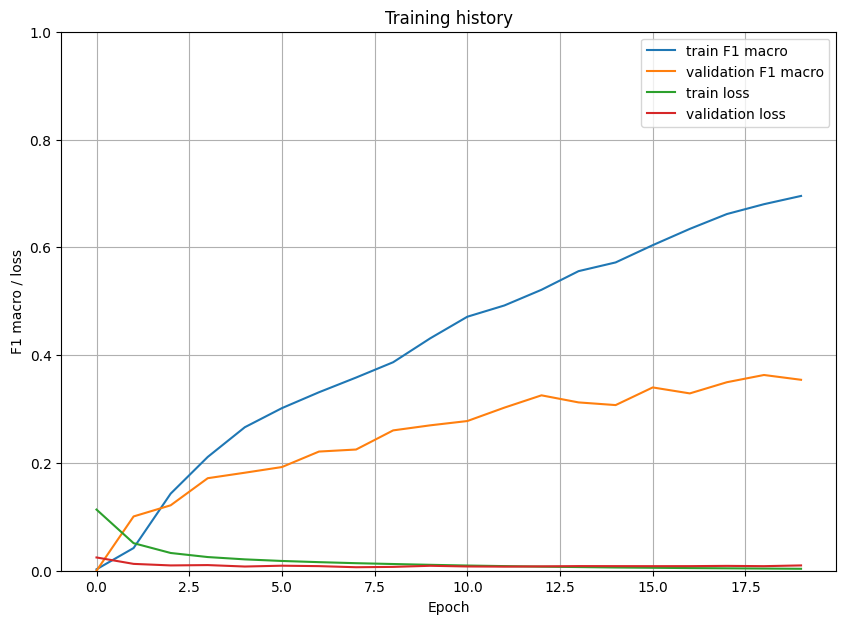

In [33]:
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(history['train_f1_macro'], label='train F1 macro')
plt.plot(history['val_f1_macro'], label='validation F1 macro')
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
plt.title('Training history')
plt.ylabel('F1 macro / loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.grid()

## Evaluation of the model

In [35]:
# Loading pretrained model (best model)
model = BERTClass(tokenizer)
model.load_state_dict(torch.load(model_dict_state_path))
model = model.to(device)

/home/tagny/.pyenv/versions/3.11.8/envs/kgl11/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [38]:
# Evaluate the model using the test data
# val_acc, val_f1_macro, val_loss = eval_model(val_data_loader, model)

In [ ]:
# The accuracy looks OK, similar to the validation accuracy
# The model generalizes well !
# val_acc

In [39]:
titles, predictions, prediction_probs, target_values = get_predictions(model, val_data_loader)

training: 100%|██████████| 2575/2575 [11:51<00:00,  3.62it/s]


In [40]:
# Generate Classification Metrics
#
# note that the total support is greater than the number of samples
# some samples have multiple lables

print(classification_report(target_values, predictions, target_names=target_list, zero_division=0))

                         precision    recall  f1-score   support

                CREATED       0.37      0.28      0.32        25
          DEATHS_NUMBER       0.19      0.80      0.31        15
                DIED_IN       0.09      0.14      0.11         7
               END_DATE       0.60      0.86      0.70       190
          GENDER_FEMALE       0.52      0.82      0.64        91
            GENDER_MALE       0.72      0.92      0.81       193
           HAS_CATEGORY       0.39      0.88      0.54       186
              HAS_COLOR       0.11      0.86      0.19        14
        HAS_CONSEQUENCE       0.26      0.86      0.40       138
       HAS_CONTROL_OVER       0.39      0.73      0.51       931
HAS_FAMILY_RELATIONSHIP       0.51      0.67      0.58        51
         HAS_FOR_HEIGHT       0.00      0.00      0.00         3
         HAS_FOR_LENGTH       0.00      0.00      0.00         5
          HAS_FOR_WIDTH       0.00      0.00      0.00         2
           HAS_LATITUDE 

In [ ]:
# import seaborn as sns
# def show_confusion_matrix(confusion_matrix):
#     hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
#     hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
#     hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
#     plt.ylabel('True category')
#     plt.xlabel('Predicted category');

In [ ]:
# cm = confusion_matrix(target_values, predictions)
# df_cm = pd.DataFrame(cm, index=target_list, columns=target_list)
# show_confusion_matrix(df_cm)

## Prepare submission

In [41]:
df_test = load_csv(os.path.join(generated_data_dir_path, "test")) #.drop(TARGET_COL, axis=1)
df_test

,text_index,e1,e2,text,relations
0,51344,0,0,Un Un <e1><FIRE>incendie</e1> a eu lieu hier m...,NaN
1,51344,1,0,Un <e2><FIRE>incendie</e2> a eu lieu hier mati...,NaN
2,51344,0,1,Un <e1><FIRE>incendie</e1> a eu lieu hier mati...,NaN
3,51344,1,1,Un incendie a eu lieu hier matin au Un incendi...,NaN
4,51344,2,0,Un <e2><FIRE>incendie</e2> a eu lieu hier mati...,NaN
...,...,...,...,...,...
182975,4998,22,20,Un braquage de banque a eu lieu à New York hie...,NaN
182976,4998,20,22,Un braquage de banque a eu lieu à New York hie...,NaN
182977,4998,22,21,Un braquage de banque a eu lieu à New York hie...,NaN
182978,4998,21,22,Un braquage de banque a eu lieu à New York hie...,NaN


In [ ]:
# df_test.head().drop(TARGET_COL, axis=1).assign(**{cat: [0]*df_test.head().shape[0] for cat in target_list})

In [42]:
test_dataset = CustomDataset(df_test.drop(TARGET_COL, axis=1).assign(**{cat: [0]*df_test.shape[0] for cat in target_list}), tokenizer, MAX_LEN, target_list)

In [43]:
TEST_BATCH_SIZE = 32

test_data_loader = torch.utils.data.DataLoader(test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [44]:
titles, predictions, prediction_probs, target_values = get_predictions(model, test_data_loader)

training: 100%|██████████| 5719/5719 [26:28<00:00,  3.60it/s]


In [45]:

ml_labeled_test_df = pd.concat(
    [
        df_test.drop(TARGET_COL, axis=1),
        pd.Series(
            mlb.inverse_transform(
                pd.DataFrame(predictions.numpy(), columns=target_list, index=df_test.index)[mlb.classes_].values
            ),
            name=TARGET_COL,
            index=df_test.index
        )
    ],
    axis=1
)
ml_labeled_test_df

,text_index,e1,e2,text,relations
0,51344,0,0,Un Un <e1><FIRE>incendie</e1> a eu lieu hier m...,()
1,51344,1,0,Un <e2><FIRE>incendie</e2> a eu lieu hier mati...,()
2,51344,0,1,Un <e1><FIRE>incendie</e1> a eu lieu hier mati...,"(IS_LOCATED_IN,)"
3,51344,1,1,Un incendie a eu lieu hier matin au Un incendi...,()
4,51344,2,0,Un <e2><FIRE>incendie</e2> a eu lieu hier mati...,()
...,...,...,...,...,...
182975,4998,22,20,Un braquage de banque a eu lieu à New York hie...,()
182976,4998,20,22,Un braquage de banque a eu lieu à New York hie...,()
182977,4998,22,21,Un braquage de banque a eu lieu à New York hie...,()
182978,4998,21,22,Un braquage de banque a eu lieu à New York hie...,()


In [46]:
text_idx_to_relations = {
    text_index: [l[0] for l in group_df.drop(["text_index", "text"], axis=1)[group_df.relations.str.len()>0].apply(lambda row: [[row.iloc[0], r, row.iloc[1]] for r in row.iloc[-1]] if len(row.iloc[-1]) > 0 else [], axis=1).values.tolist()]
 for text_index, group_df in tqdm(ml_labeled_test_df.groupby("text_index"))
}

100%|██████████| 400/400 [00:00<00:00, 647.03it/s]


In [47]:
text_idx_to_relations[13]

[[1, 'GENDER_MALE', 1],
 [2, 'INITIATED', 0],
 [2, 'IS_IN_CONTACT_WITH', 1],
 [2, 'GENDER_MALE', 2],
 [3, 'INITIATED', 0],
 [3, 'IS_IN_CONTACT_WITH', 1],
 [1, 'IS_IN_CONTACT_WITH', 3],
 [2, 'IS_IN_CONTACT_WITH', 3],
 [4, 'IS_IN_CONTACT_WITH', 1],
 [4, 'HAS_CONTROL_OVER', 2],
 [2, 'IS_IN_CONTACT_WITH', 4],
 [4, 'IS_IN_CONTACT_WITH', 3],
 [3, 'IS_IN_CONTACT_WITH', 4],
 [5, 'IS_IN_CONTACT_WITH', 1],
 [1, 'IS_IN_CONTACT_WITH', 5],
 [5, 'IS_IN_CONTACT_WITH', 2],
 [2, 'IS_IN_CONTACT_WITH', 5],
 [5, 'IS_IN_CONTACT_WITH', 3],
 [3, 'IS_IN_CONTACT_WITH', 5],
 [5, 'IS_IN_CONTACT_WITH', 4],
 [4, 'IS_PART_OF', 5],
 [1, 'HAS_CONTROL_OVER', 6],
 [3, 'IS_PART_OF', 6],
 [1, 'HAS_CONTROL_OVER', 7],
 [2, 'IS_LOCATED_IN', 7],
 [3, 'IS_LOCATED_IN', 7],
 [4, 'IS_LOCATED_IN', 7],
 [5, 'OPERATES_IN', 7],
 [6, 'OPERATES_IN', 7],
 [8, 'IS_LOCATED_IN', 7],
 [3, 'HAS_CONTROL_OVER', 9],
 [2, 'HAS_CONTROL_OVER', 10],
 [3, 'HAS_CONTROL_OVER', 10],
 [4, 'HAS_CONTROL_OVER', 10],
 [0, 'IS_LOCATED_IN', 11],
 [3, 'HAS_CO

In [48]:
test_index = load_test_raw_data().index
test_index

Index([ 1204,  4909,  2353,  1210, 41948, 41092, 41094, 51395,   194, 41515,
       ...
       41765,  4961,  4969, 51257, 51446, 51452, 51491, 51492, 51495, 51742],
      dtype='int64', name='id', length=400)

In [49]:
submission_df = pd.DataFrame({"id": list(text_idx_to_relations.keys()), TARGET_COL: list(text_idx_to_relations.values())}).set_index("id").loc[load_test_raw_data().index]
submission_df = submission_df.assign(relations= submission_df.relations.map(lambda x: str(x).replace("'", '"')))
submission_df

,relations
id,
1204,"[[1, ""GENDER_MALE"", 1], [2, ""HAS_FAMILY_RELATI..."
4909,"[[1, ""IS_AT_ODDS_WITH"", 0], [0, ""IS_AT_ODDS_WI..."
2353,"[[1, ""INITIATED"", 0], [1, ""GENDER_MALE"", 1], [..."
1210,"[[0, ""STARTED_IN"", 1], [0, ""STARTED_IN"", 2], [..."
41948,"[[1, ""HAS_CONSEQUENCE"", 0], [2, ""INITIATED"", 0..."
...,...
51452,"[[1, ""HAS_CONSEQUENCE"", 0], [0, ""HAS_CONSEQUEN..."
51491,"[[1, ""INITIATED"", 0], [1, ""GENDER_FEMALE"", 1],..."
51492,"[[2, ""GENDER_MALE"", 2], [2, ""IS_PART_OF"", 3], ..."


In [50]:
submission_df.to_csv(submission_path)

In [51]:
print(f"titles:{len(titles)} \npredictions:{predictions.shape} \nprediction_probs:{prediction_probs.shape} \ntarget_values:{target_values.shape}")

titles:182980 
predictions:torch.Size([182980, 37]) 
prediction_probs:torch.Size([182980, 37]) 
target_values:torch.Size([182980, 37])
